## Importing Libraries

In [45]:
from nltk.lm import MLE
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import pandas as pd
import math
import numpy as np
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/Vraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/Vraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Reading csv file

In [46]:
file_path = 'raw_reddit_data_filtered.csv'
df = pd.read_csv(file_path)

print(df.head(10))
stopwords = set(stopwords.words("english"))

   Unnamed: 0  Post_ID Comment_ID  \
0           1  108l3ho    j3vlnat   
1           2  10j6oqj    j5j34zb   
2           3  10j6oqj    j5jbs3f   
3           4  10j6oqj    j5jfczd   
4           5  10o9tvi    j6h1ko8   
5           6  10o9tvi    j88hrgq   
6           7  10o9tvi    jh0junq   
7           8  10o9tvi    j94k8o3   
8           9  10o9tvi    j94kbno   
9          10  10yjhn9    j7yqwxx   

                                             Comment Majority_Sentiment  
0  Some of them yes but this one i got it from my...            Neutral  
1        I keep mine in my phone cover for good luck           Positive  
2  Hang on to it! These are rare to come by as th...            Neutral  
3  Yeah?! Cool, I got this from my classmate in 2...           Positive  
4  Check out the Kaja Throm! Beautiful marketplac...           Positive  
5  Out of curiosity what field of work brings you...           Positive  
6  Definitely Dechenphu Lhakhang/Goenkhang! Seren...           Positive  


## Sentence Tokenize, train-test split, pre-processing 

In [47]:
# Define regular expressions for preprocessing
regex_pattern_for_links = r'http\S+|www\S+|\@\w+|\#'
regex_pattern_for_special_chars = r'[^A-Za-z0-9\s]'

# Function to preprocess a single comment
def preprocess_comment(comment):
    # Remove links and special characters
    comment = re.sub(regex_pattern_for_links, '', comment)
    comment = re.sub(regex_pattern_for_special_chars, '', comment)
    
    # Convert to lowercase and split into words
    comment = comment.lower().split()

    # Remove empty words
    comment = [word for word in comment if word not in stopwords]

    return comment

# Tokenize sentences from the 'Comment' column in your DataFrame
sentences = [sent_tokenize(comment) for comment in df['Comment']]

# Preprocess and flatten the sentences
processed_comments = [preprocess_comment(comment) for sentence in sentences for comment in sentence]

# Set a random seed for reproducibility
np.random.seed(2)
processed_comments = processed_comments

# Shuffle the sentences randomly
np.random.shuffle(processed_comments)

# Calculate the index for the split (80% for training)
split_index = int(0.8 * len(processed_comments))

# Split the data into training and testing sets
# Data for Unigram
processed_corpus_uni = list(processed_comments[:split_index])
processed_test_uni = list(processed_comments[split_index:])             

# Data for eeach N-Gram except Unigram
processed_corpus= []
for sentence in processed_corpus_uni:
    sentence_with_tags = ["<s>"] + sentence + ["</s>"]
    processed_corpus.append(sentence_with_tags)

processed_test = []
for sentence in processed_test_uni:
    sentence_with_tags = ["<s>"] + sentence + ["</s>"]
    processed_test.append(sentence_with_tags)


In [48]:
print(len(processed_corpus_uni))
print(len(processed_test_uni))

268411
67103


## Without Smoothing

### Unigram

In [49]:
class Unigram:

    def __init__(self):
        self.unigram_freq = {}
        self.total_tokens = 0

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            for token in sentence:
                self.total_tokens += 1
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1

    def unigram_probability(self, token):
        if token in self.unigram_freq:
            return self.unigram_freq[token] / self.total_tokens
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 0:
                sentence_probability = 1.0
                for token in sentence:
                    token_probability = self.unigram_probability(token)
                    sentence_probability *= token_probability
                if sentence_probability != 0:
                    perplexity_values.append(
                        (math.pow(sentence_probability, -1 / len(sentence))))
                else:
                    # To take care of the very small values
                    perplexity_values.append(
                        (math.pow(1e-25, -1 / len(sentence))))

        return sum(perplexity_values) / len(perplexity_values)

In [50]:
model = Unigram()
model.fit(processed_corpus_uni)

perplexity = model.perplexity(processed_corpus_uni)
print("Perplexity:", perplexity)

Perplexity: 17386.098568893845


### Bigram

In [51]:
class Bigram:

    def __init__(self):
        self.bigram_freq = {}
        self.unigram_freq = {}

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token = None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1

                if prev_token is not None:
                    if (prev_token, token) in self.bigram_freq:
                        self.bigram_freq[(prev_token, token)] += 1
                    else:
                        self.bigram_freq[(prev_token, token)] = 1
                prev_token = token

    def bigram_probability(self, prev_token, token):
        if (prev_token, token) in self.bigram_freq:
            return self.bigram_freq[(prev_token, token)] / self.unigram_freq[prev_token]
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 1:
                sentence_probability = 1.0
                prev_token = sentence[0]
                for token in sentence[1:]:
                    token_probability = self.bigram_probability(
                        prev_token, token)
                    sentence_probability *= token_probability
                    prev_token = token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))
                else:
                    # To take care of very small values
                    perplexity_values.append(
                        math.pow(1e-25, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [52]:
model = Bigram()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 903365.5932980984


### Trigram

In [53]:
class Trigram:

    def __init__(self):
        self.trigram_freq = {}
        self.bigram_freq = {}

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1 = None
            prev_token2 = None
            for token in sentence:
                if prev_token1 is not None and prev_token2 is not None:
                    trigram = (prev_token1, prev_token2, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                    bigram = (prev_token1, prev_token2)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1 = prev_token2
                prev_token2 = token

    def trigram_probability(self, prev_token1, prev_token2, token):
        trigram = (prev_token1, prev_token2, token)
        if trigram in self.trigram_freq:
            return self.trigram_freq[trigram] / self.bigram_freq[(prev_token1, prev_token2)]
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 2:
                sentence_probability = 1.0
                prev_token1 = sentence[0]
                prev_token2 = sentence[1]
                for token in sentence[2:]:
                    token_probability = self.trigram_probability(
                        prev_token1, prev_token2, token)
                    sentence_probability *= token_probability
                    prev_token1 = prev_token2
                    prev_token2 = token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))
                else:
                    # To take care of very small values
                    perplexity_values.append(
                        math.pow(1e-25, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [54]:
model = Trigram()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 2064308.7291279095


### Quadgram

In [55]:
class Quadgram:

    def __init__(self):
        self.quadgram_freq = {}
        self.trigram_freq = {}

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1 = None
            prev_token2 = None
            prev_token3 = None
            for token in sentence:
                if prev_token1 is not None and prev_token2 is not None and prev_token3 is not None:
                    quadgram = (prev_token1, prev_token2, prev_token3, token)
                    if quadgram in self.quadgram_freq:
                        self.quadgram_freq[quadgram] += 1
                    else:
                        self.quadgram_freq[quadgram] = 1

                    trigram = (prev_token1, prev_token2, prev_token3)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                prev_token1 = prev_token2
                prev_token2 = prev_token3
                prev_token3 = token

    def quadgram_probability(self, prev_token1, prev_token2, prev_token3, token):
        quadgram = (prev_token1, prev_token2, prev_token3, token)
        if quadgram in self.quadgram_freq:
            return self.quadgram_freq[quadgram] / self.trigram_freq[(prev_token1, prev_token2, prev_token3)]
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 3:
                sentence_probability = 1.0
                prev_token1 = sentence[0]
                prev_token2 = sentence[1]
                prev_token3 = sentence[2]
                for token in sentence[3:]:
                    token_probability = self.quadgram_probability(
                        prev_token1, prev_token2, prev_token3, token)
                    sentence_probability *= token_probability
                    prev_token1 = prev_token2
                    prev_token2 = prev_token3
                    prev_token3 = token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))
                else:
                    # To take care of very small values
                    perplexity_values.append(
                        math.pow(1e-25, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [56]:
model = Quadgram()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 117377.71842166435


### Plots

Unigram Perplexity: 1.5123508654019235e+22
Bigram Perplexity: 903365.5932980984
Trigram Perplexity: 2064308.7291279095
Quadgram Perplexity: 117377.71842166435


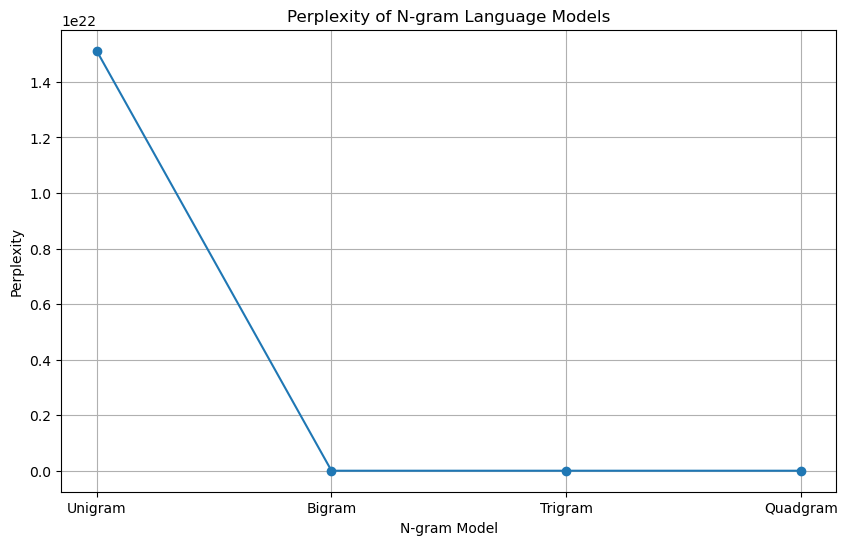

In [57]:
import matplotlib.pyplot as plt

n_gram_models = [Unigram(), Bigram(), Trigram(), Quadgram()]

corpus = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data = [processed_test_uni, processed_test, processed_test, processed_test]

perplexities = []

n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

for i, model in enumerate(n_gram_models):
    model.fit(corpus[i])
    perplexity = model.perplexity(test_data[i])
    perplexities.append(perplexity)
    print(f"{n_gram_labels[i]} Perplexity: {perplexity}")


plt.figure(figsize=(10, 6))
plt.plot(n_gram_labels, perplexities, marker='o', linestyle='-')
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.title("Perplexity of N-gram Language Models")
plt.grid(True)
plt.show()


## With Laplace Smoothing

### Unigram

In [58]:
class Unigram_Laplace:

    def __init__(self):
        self.unigram_freq = {}
        self.total_tokens = 0
        self.V = 0

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            for token in sentence:
                self.total_tokens += 1
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

    def unigram_probability(self, token):
        if token in self.unigram_freq:
            return (self.unigram_freq[token] + 1) / (self.total_tokens + self.V)
        else:
            return (1) / (self.total_tokens + self.V)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 0:
                sentence_probability = 1.0
                for token in sentence:
                    token_probability = self.unigram_probability(token)
                    sentence_probability *= token_probability
                if sentence_probability != 0:
                    perplexity_values.append(
                        (math.pow(sentence_probability, -1 / len(sentence))))

        return sum(perplexity_values) / len(perplexity_values)

In [59]:
model = Unigram_Laplace()
model.fit(processed_corpus_uni)

perplexity = model.perplexity(processed_test_uni)
print("Perplexity:", perplexity)

Perplexity: 17846.820271001903


### Bigram

In [60]:
class Bigram_Laplace:

    def __init__(self):
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token = None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token is not None:
                    if (prev_token, token) in self.bigram_freq:
                        self.bigram_freq[(prev_token, token)] += 1
                    else:
                        self.bigram_freq[(prev_token, token)] = 1
                prev_token = token

    def bigram_probability(self, prev_token, token):
        if (prev_token, token) in self.bigram_freq:
            return (self.bigram_freq[(prev_token, token)] + 1) / (self.unigram_freq[prev_token] + self.V)
        else:
            if prev_token in self.unigram_freq:
                return (1) / (self.unigram_freq[prev_token] + self.V)
            else:
                return (1) / (self.V)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 1:
                sentence_probability = 1.0
                prev_token = sentence[0]
                for token in sentence[1:]:
                    token_probability = self.bigram_probability(
                        prev_token, token)
                    sentence_probability *= token_probability
                    prev_token = token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [61]:
model = Bigram_Laplace()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 5721.069367024385


### Trigram

In [62]:
class Trigram_Laplace:

    def __init__(self):
        self.trigram_freq = {}
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1, prev_token2 = None, None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token1 is not None and prev_token2 is not None:
                    trigram = (prev_token1, prev_token2, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                if prev_token2 is not None:
                    bigram = (prev_token2, token)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1, prev_token2 = prev_token2, token

    def trigram_probability(self, prev_token1, prev_token2, token):
        trigram = (prev_token1, prev_token2, token)
        if trigram in self.trigram_freq:
            return (self.trigram_freq[trigram] + 1) / (self.bigram_freq.get((prev_token1, prev_token2), 0) + self.V)
        else:
            if (prev_token1, prev_token2) in self.bigram_freq:
                return (1) / (self.bigram_freq[(prev_token1, prev_token2)] + self.V)
            else:
                return (1) / (self.V)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 2:
                sentence_probability = 1.0
                prev_token1, prev_token2 = sentence[0], sentence[1]
                for token in sentence[2:]:
                    token_probability = self.trigram_probability(
                        prev_token1, prev_token2, token)
                    sentence_probability *= token_probability
                    prev_token1, prev_token2 = prev_token2, token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [63]:
model = Trigram_Laplace()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 6025.705074666868


### Quadgram

In [64]:
class Quadgram_Laplace:

    def __init__(self):
        self.quadgram_freq = {}
        self.trigram_freq = {}
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1, prev_token2, prev_token3 = None, None, None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token1 is not None and prev_token2 is not None and prev_token3 is not None:
                    quadgram = (prev_token1, prev_token2, prev_token3, token)
                    if quadgram in self.quadgram_freq:
                        self.quadgram_freq[quadgram] += 1
                    else:
                        self.quadgram_freq[quadgram] = 1

                if prev_token2 is not None and prev_token3 is not None:
                    trigram = (prev_token2, prev_token3, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                if prev_token3 is not None:
                    bigram = (prev_token3, token)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1, prev_token2, prev_token3 = prev_token2, prev_token3, token

    def quadgram_probability(self, prev_token1, prev_token2, prev_token3, token):
        quadgram = (prev_token1, prev_token2, prev_token3, token)
        if quadgram in self.quadgram_freq:
            return (self.quadgram_freq[quadgram] + 1) / (self.trigram_freq.get((prev_token1, prev_token2, prev_token3), 0) + self.V)
        else:
            if (prev_token1, prev_token2, prev_token3) in self.trigram_freq:
                return (1) / (self.trigram_freq[(prev_token1, prev_token2, prev_token3)] + self.V)
            else:
                return (1) / (self.V)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 3:
                sentence_probability = 1.0
                prev_token1, prev_token2, prev_token3 = sentence[0], sentence[1], sentence[2]
                for token in sentence[3:]:
                    token_probability = self.quadgram_probability(
                        prev_token1, prev_token2, prev_token3, token)
                    sentence_probability *= token_probability
                    prev_token1, prev_token2, prev_token3 = prev_token2, prev_token3, token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [65]:
model = Quadgram_Laplace()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 3223.4886425777263


### Plots

Unigram Perplexity: 17846.820271001903
Bigram Perplexity: 5721.069367024385
Trigram Perplexity: 6025.705074666868
Quadgram Perplexity: 3223.4886425777263


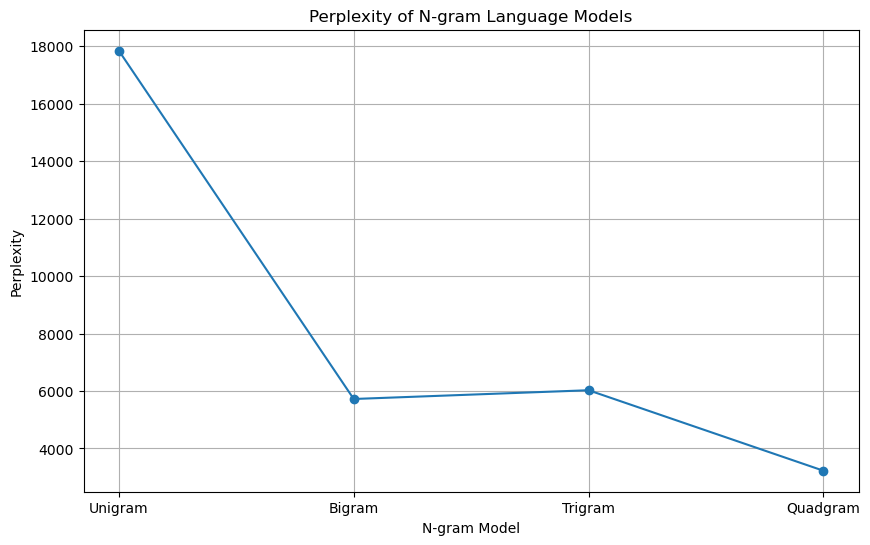

In [66]:
import matplotlib.pyplot as plt

n_gram_models = [Unigram_Laplace(), Bigram_Laplace(), Trigram_Laplace(), Quadgram_Laplace()]

corpus = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data = [processed_test_uni, processed_test, processed_test, processed_test]

perplexities = []

n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

for i, model in enumerate(n_gram_models):
    model.fit(corpus[i])
    perplexity = model.perplexity(test_data[i])
    perplexities.append(perplexity)
    print(f"{n_gram_labels[i]} Perplexity: {perplexity}")


plt.figure(figsize=(10, 6))
plt.plot(n_gram_labels, perplexities, marker='o', linestyle='-')
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.title("Perplexity of N-gram Language Models")
plt.grid(True)
plt.show()


## With Additive Smoothing

### Unigram

In [67]:
class Unigram_Additive:

    def __init__(self):
        self.unigram_freq = {}
        self.total_tokens = 0
        self.V = 0
        self.alpha=0.5

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            for token in sentence:
                self.total_tokens += 1
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

    def unigram_probability(self, token):
        if token in self.unigram_freq:
            return (self.unigram_freq[token] + 1*self.alpha) / (self.total_tokens + self.V*self.alpha)
        else:
            return (1*self.alpha) / (self.total_tokens + self.V*self.alpha)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 0:
                sentence_probability = 1.0
                for token in sentence:
                    token_probability = self.unigram_probability(token)
                    sentence_probability *= token_probability
                if sentence_probability != 0:
                    perplexity_values.append(
                        (math.pow(sentence_probability, -1 / len(sentence))))

        return sum(perplexity_values) / len(perplexity_values)

In [68]:
model = Unigram_Additive()
model.fit(processed_corpus_uni)

perplexity = model.perplexity(processed_test_uni)
print("Perplexity:", perplexity)

Perplexity: 23216.1197684928


### Bigram

In [69]:
class Bigram_Additive:

    def __init__(self):
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0
        self.alpha=0.5

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token = None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token is not None:
                    if (prev_token, token) in self.bigram_freq:
                        self.bigram_freq[(prev_token, token)] += 1
                    else:
                        self.bigram_freq[(prev_token, token)] = 1
                prev_token = token

    def bigram_probability(self, prev_token, token):
        if (prev_token, token) in self.bigram_freq:
            return (self.bigram_freq[(prev_token, token)] + 1*self.alpha) / (self.unigram_freq[prev_token] + self.V*self.alpha)
        else:
            if prev_token in self.unigram_freq:
                return (1*self.alpha) / (self.unigram_freq[prev_token] + self.V*self.alpha)
            else:
                return (1*self.alpha) / (self.V*self.alpha)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 1:
                sentence_probability = 1.0
                prev_token = sentence[0]
                for token in sentence[1:]:
                    token_probability = self.bigram_probability(
                        prev_token, token)
                    sentence_probability *= token_probability
                    prev_token = token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [70]:
model = Bigram_Additive()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 4660.14958528491


### Trigram

In [71]:
class Trigram_Additive:

    def __init__(self):
        self.trigram_freq = {}
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0
        self.alpha=0.5

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1, prev_token2 = None, None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token1 is not None and prev_token2 is not None:
                    trigram = (prev_token1, prev_token2, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                if prev_token2 is not None:
                    bigram = (prev_token2, token)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1, prev_token2 = prev_token2, token

    def trigram_probability(self, prev_token1, prev_token2, token):
        trigram = (prev_token1, prev_token2, token)
        if trigram in self.trigram_freq:
            return (self.trigram_freq[trigram] + 1*self.alpha) / (self.bigram_freq[(prev_token1, prev_token2)]+ self.V*self.alpha)
        else:
            if (prev_token1, prev_token2) in self.bigram_freq:
                return (1*self.alpha) / (self.bigram_freq[(prev_token1, prev_token2)] + self.V*self.alpha)
            else:
                return (1*self.alpha) / (self.V*self.alpha)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 2:
                sentence_probability = 1.0
                prev_token1, prev_token2 = sentence[0], sentence[1]
                for token in sentence[2:]:
                    token_probability = self.trigram_probability(
                        prev_token1, prev_token2, token)
                    sentence_probability *= token_probability
                    prev_token1, prev_token2 = prev_token2, token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [72]:
model = Trigram_Additive()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 5621.262617186284


### Quadgram

In [73]:
class Quadgram_Additive:

    def __init__(self):
        self.quadgram_freq = {}
        self.trigram_freq = {}
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.V = 0
        self.alpha=0.5

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1, prev_token2, prev_token3 = None, None, None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1
                    self.V += 1

                if prev_token1 is not None and prev_token2 is not None and prev_token3 is not None:
                    quadgram = (prev_token1, prev_token2, prev_token3, token)
                    if quadgram in self.quadgram_freq:
                        self.quadgram_freq[quadgram] += 1
                    else:
                        self.quadgram_freq[quadgram] = 1

                if prev_token2 is not None and prev_token3 is not None:
                    trigram = (prev_token2, prev_token3, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                if prev_token3 is not None:
                    bigram = (prev_token3, token)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1, prev_token2, prev_token3 = prev_token2, prev_token3, token

    def quadgram_probability(self, prev_token1, prev_token2, prev_token3, token):
        quadgram = (prev_token1, prev_token2, prev_token3, token)
        if quadgram in self.quadgram_freq:
            return (self.quadgram_freq[quadgram] + 1*self.alpha) / (self.trigram_freq[(prev_token1, prev_token2, prev_token3)]+ self.V*self.alpha)
        else:
            if (prev_token1, prev_token2, prev_token3) in self.trigram_freq:
                return (1*self.alpha) / (self.trigram_freq[(prev_token1, prev_token2, prev_token3)] + self.V*self.alpha)
            else:
                return (1*self.alpha) / (self.V*self.alpha)

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 3:
                sentence_probability = 1.0
                prev_token1, prev_token2, prev_token3 = sentence[0], sentence[1], sentence[2]
                for token in sentence[3:]:
                    token_probability = self.quadgram_probability(
                        prev_token1, prev_token2, prev_token3, token)
                    sentence_probability *= token_probability
                    prev_token1, prev_token2, prev_token3 = prev_token2, prev_token3, token
                if sentence_probability != 0:
                    perplexity_values.append(
                        math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [74]:
model = Quadgram_Additive()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 3111.5597963610976


### Plots

Unigram Perplexity: 23216.1197684928
Bigram Perplexity: 4660.14958528491
Trigram Perplexity: 5621.262617186284
Quadgram Perplexity: 3111.5597963610976


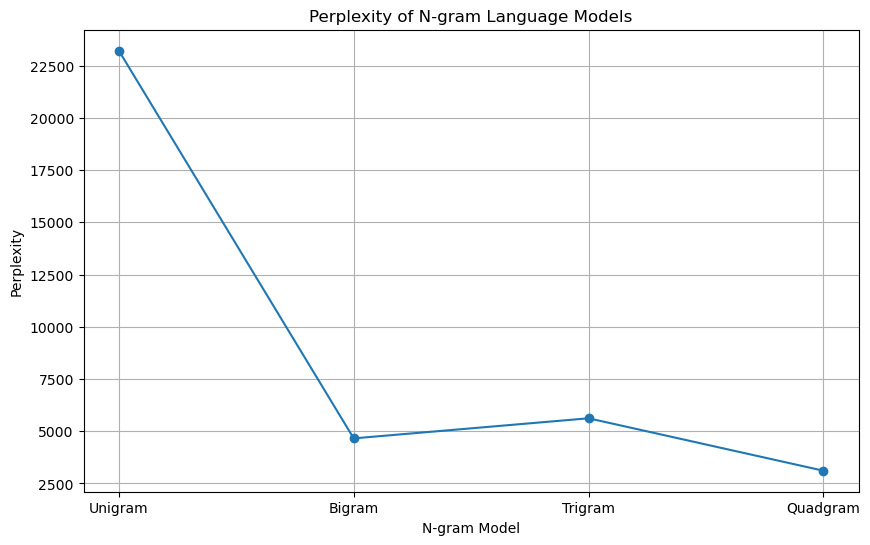

In [75]:
import matplotlib.pyplot as plt

n_gram_models = [Unigram_Additive(), Bigram_Additive(), Trigram_Additive(), Quadgram_Additive()]

corpus = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data = [processed_test_uni, processed_test, processed_test, processed_test]

perplexities = []

n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

for i, model in enumerate(n_gram_models):
    model.fit(corpus[i])
    perplexity = model.perplexity(test_data[i])
    perplexities.append(perplexity)
    print(f"{n_gram_labels[i]} Perplexity: {perplexity}")


plt.figure(figsize=(10, 6))
plt.plot(n_gram_labels, perplexities, marker='o', linestyle='-')
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.title("Perplexity of N-gram Language Models")
plt.grid(True)
plt.show()


## With Good Turing Smoothing

### Unigram

In [76]:
class Unigram_GoodTuring:

    def __init__(self):
        self.unigram_freq = {}
        self.total_tokens = 0
        self.counts = {}  # For Good-Turing counts

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            for token in sentence:
                self.total_tokens += 1
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1

        # Calculate Good-Turing counts
        for count in self.unigram_freq.values():
            if count in self.counts:
                self.counts[count] += 1
            else:
                self.counts[count] = 1

    def unigram_probability(self, token):
        if token in self.unigram_freq:
            count = self.unigram_freq[token]
        else:
            count = 0

        if count in self.counts:
            Nc = self.counts[count]  # Number of times a count appears
            Nc_plus_1 = self.counts.get(count + 1, 0)  # Number of times count+1 appears
            if Nc != 0 and Nc_plus_1 != 0:
                return (count + 1) * (Nc_plus_1 / Nc) / self.total_tokens
            else:
                return count / self.total_tokens
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 0:
                sentence_probability = 1.0
                for token in sentence:
                    token_probability = self.unigram_probability(token)
                    sentence_probability *= token_probability
                if sentence_probability != 0:
                    perplexity_values.append((math.pow(sentence_probability, -1 / len(sentence))))

        return sum(perplexity_values) / len(perplexity_values)


In [77]:
model = Unigram_GoodTuring()
model.fit(processed_corpus_uni)

perplexity = model.perplexity(processed_test_uni)
print("Perplexity:", perplexity)

Perplexity: 15717.081839426002


### Bigram

In [78]:
class Bigram_GoodTuring:

    def __init__(self):
        self.bigram_freq = {}
        self.unigram_freq = {}
        self.counts = {}  # For Good-Turing counts

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token = None
            for token in sentence:
                if token in self.unigram_freq:
                    self.unigram_freq[token] += 1
                else:
                    self.unigram_freq[token] = 1

                if prev_token is not None:
                    bigram = (prev_token, token)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1
                prev_token = token

        # Calculate Good-Turing counts
        for count in self.bigram_freq.values():
            if count in self.counts:
                self.counts[count] += 1
            else:
                self.counts[count] = 1

    def bigram_probability(self, prev_token, token):
        bigram = (prev_token, token)

        if bigram in self.bigram_freq:
            count = self.bigram_freq[bigram]
        else:
            count = 0

        if prev_token in self.unigram_freq:
            unigram_count = self.unigram_freq[prev_token]
        else:
            unigram_count = 0

        if count in self.counts:
            Nc = self.counts[count]  # Number of times a count appears
            Nc_plus_1 = self.counts.get(count + 1, 0)  # Number of times count+1 appears

            if Nc != 0 and Nc_plus_1 != 0:
                return (count + 1) * (Nc_plus_1 / Nc) / unigram_count
            else:
                return count / unigram_count
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 1:
                sentence_probability = 1.0
                prev_token = sentence[0]
                for token in sentence[1:]:
                    token_probability = self.bigram_probability(prev_token, token)
                    sentence_probability *= token_probability
                    prev_token = token
                if sentence_probability != 0:
                    perplexity_values.append(math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)


In [79]:
model = Bigram_GoodTuring()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 82.27606618444045


### Trigram

In [80]:
class Trigram_GoodTuring:

    def __init__(self):
        self.trigram_freq = {}
        self.bigram_freq = {}
        self.counts = {}  # For Good-Turing counts

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1 = None
            prev_token2 = None
            for token in sentence:
                if prev_token1 is not None and prev_token2 is not None:
                    trigram = (prev_token1, prev_token2, token)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1

                    bigram = (prev_token1, prev_token2)
                    if bigram in self.bigram_freq:
                        self.bigram_freq[bigram] += 1
                    else:
                        self.bigram_freq[bigram] = 1

                prev_token1 = prev_token2
                prev_token2 = token

        # Calculate Good-Turing counts for trigrams
        for count in self.trigram_freq.values():
            if count in self.counts:
                self.counts[count] += 1
            else:
                self.counts[count] = 1

    def trigram_probability(self, prev_token1, prev_token2, token):
        trigram = (prev_token1, prev_token2, token)

        if trigram in self.trigram_freq:
            count = self.trigram_freq[trigram]
        else:
            count = 0

        bigram = (prev_token1, prev_token2)
        if bigram in self.bigram_freq:
            bigram_count = self.bigram_freq[bigram]
        else:
            bigram_count = 0

        if count in self.counts:
            Nc = self.counts[count]  # Number of times a count appears
            Nc_plus_1 = self.counts.get(count + 1, 0)  # Number of times count+1 appears

            if Nc != 0 and Nc_plus_1 != 0:
                return (count + 1) * (Nc_plus_1 / Nc) / bigram_count
            else:
                return count / bigram_count
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 2:
                sentence_probability = 1.0
                prev_token1 = sentence[0]
                prev_token2 = sentence[1]
                for token in sentence[2:]:
                    token_probability = self.trigram_probability(prev_token1, prev_token2, token)
                    sentence_probability *= token_probability
                    prev_token1 = prev_token2
                    prev_token2 = token
                if sentence_probability != 0:
                    perplexity_values.append(math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)


In [81]:
model = Trigram_GoodTuring()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 5.800523343118439


### Quadgram

In [82]:
class Quadgram_GoodTuring:

    def __init__(self):
        self.quadgram_freq = {}
        self.trigram_freq = {}

    def fit(self, processed_corpus):
        for sentence in processed_corpus:
            prev_token1 = None
            prev_token2 = None
            prev_token3 = None
            for token in sentence:
                if prev_token1 is not None and prev_token2 is not None and prev_token3 is not None:
                    quadgram = (prev_token1, prev_token2, prev_token3, token)
                    if quadgram in self.quadgram_freq:
                        self.quadgram_freq[quadgram] += 1
                    else:
                        self.quadgram_freq[quadgram] = 1

                    trigram = (prev_token1, prev_token2, prev_token3)
                    if trigram in self.trigram_freq:
                        self.trigram_freq[trigram] += 1
                    else:
                        self.trigram_freq[trigram] = 1
                
                prev_token1 = prev_token2
                prev_token2 = prev_token3
                prev_token3 = token

    def quadgram_probability(self, prev_token1, prev_token2, prev_token3, token):
        quadgram = (prev_token1, prev_token2, prev_token3, token)
        if quadgram in self.quadgram_freq:
            return self.quadgram_freq[quadgram] / self.trigram_freq[(prev_token1, prev_token2, prev_token3)]
        else:
            return 0

    def perplexity(self, processed_test):
        perplexity_values = []
        for sentence in processed_test:
            if len(sentence) > 3:
                sentence_probability = 1.0
                prev_token1 = sentence[0]
                prev_token2 = sentence[1]
                prev_token3 = sentence[2]
                for token in sentence[3:]:
                    token_probability = self.quadgram_probability(prev_token1, prev_token2, prev_token3, token)
                    sentence_probability *= token_probability
                    prev_token1 = prev_token2
                    prev_token2 = prev_token3
                    prev_token3 = token
                if sentence_probability != 0:
                    perplexity_values.append(math.pow(sentence_probability, -1 / len(sentence)))

        return sum(perplexity_values) / len(perplexity_values)

In [83]:
model = Quadgram_GoodTuring()
model.fit(processed_corpus)

perplexity = model.perplexity(processed_test)
print("Perplexity:", perplexity)

Perplexity: 1.149506504412479


### Plots

Unigram Perplexity: 15717.081839426002
Bigram Perplexity: 82.27606618444045
Trigram Perplexity: 5.800523343118439
Quadgram Perplexity: 1.149506504412479


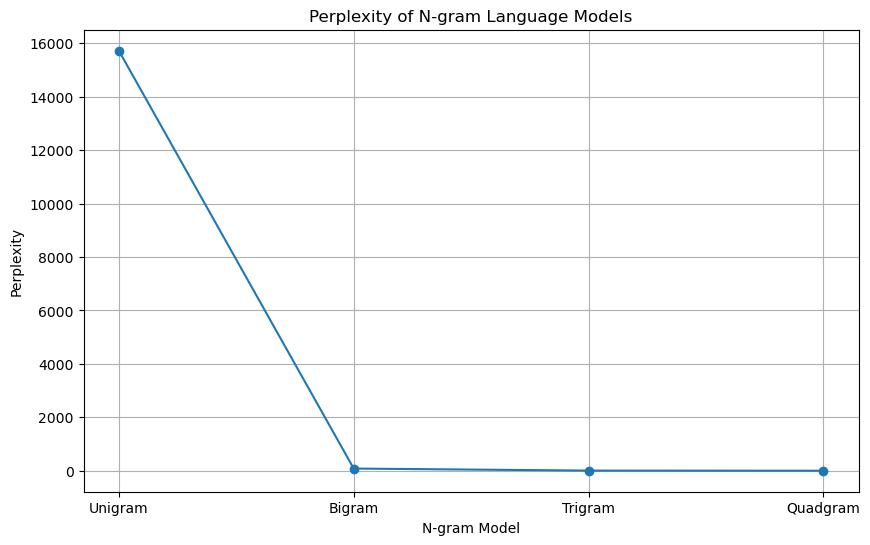

In [84]:
n_gram_models = [Unigram_GoodTuring(), Bigram_GoodTuring(), Trigram_GoodTuring(), Quadgram_GoodTuring()]

corpus = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data = [processed_test_uni, processed_test, processed_test, processed_test]

perplexities = []

n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

for i, model in enumerate(n_gram_models):
    model.fit(corpus[i])
    perplexity = model.perplexity(test_data[i])
    perplexities.append(perplexity)
    print(f"{n_gram_labels[i]} Perplexity: {perplexity}")


plt.figure(figsize=(10, 6))
plt.plot(n_gram_labels, perplexities, marker='o', linestyle='-')
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.title("Perplexity of N-gram Language Models")
plt.grid(True)
plt.show()


## Laplace vs Additive Smoothing

  N-gram Model  Additive Smoothing  Laplace Smoothing
0      Unigram        23216.119768       17603.901090
1       Bigram         4660.149585        4567.153851
2      Trigram         5621.262617        1957.548537
3     Quadgram         3111.559796        1946.363086


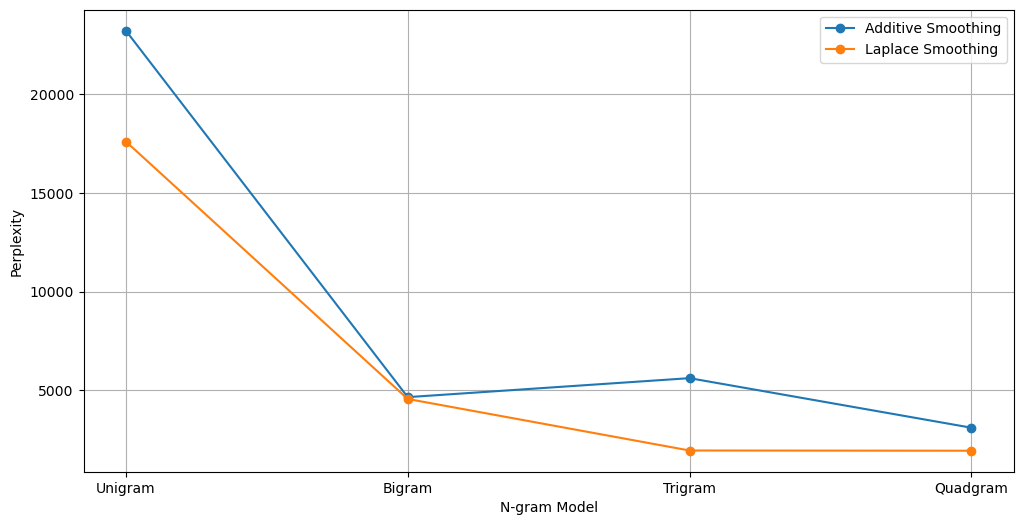

In [85]:
n_gram_models1 = [Unigram_Additive(), Bigram_Additive(), Trigram_Additive(), Quadgram_Additive()]
corpus1 = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data1 = [processed_test_uni, processed_test, processed_test, processed_test]

n_gram_models2 = [Unigram_Laplace(), Bigram_Laplace(), Trigram_Laplace(), Quadgram_Laplace()]
corpus2 = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data2 = [processed_test_uni, processed_test, processed_test, processed_test]

n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

perplexities1 = []
perplexities2 = [17603.901090 ,4567.153851 , 1957.548537 ,1946.363086]

for i, model in enumerate(n_gram_models1):
    model.fit(corpus1[i])
    perplexity = model.perplexity(test_data1[i])
    perplexities1.append(perplexity)


data = {
    "N-gram Model": n_gram_labels,
    "Additive Smoothing": perplexities1,
    "Laplace Smoothing": perplexities2
}
df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = np.arange(len(n_gram_labels))

plt.plot(x, perplexities1, marker='o', linestyle='-', label="Additive Smoothing")
plt.plot(x, perplexities2, marker='o', linestyle='-', label="Laplace Smoothing")
plt.xticks(x, n_gram_labels)
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

print(df)

plt.show()


## Good Turing Smoothing vs Additive Smoothing

  N-gram Model  Good Turing Smoothing  Additive Smoothing
0      Unigram           15717.081839        23216.119768
1       Bigram              82.276066         4660.149585
2      Trigram               5.800523         5621.262617
3     Quadgram               1.149507         3111.559796


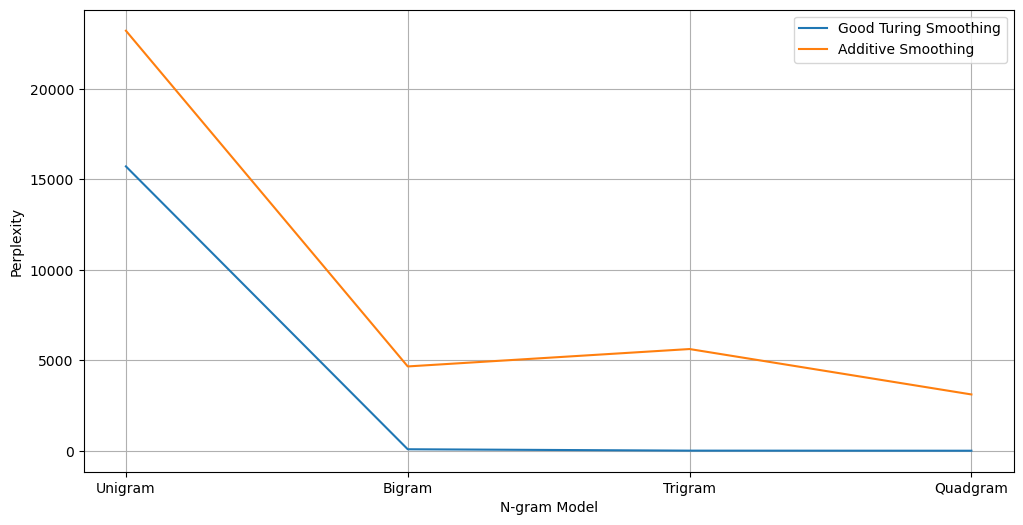

In [86]:
n_gram_models1 = [Unigram_GoodTuring(), Bigram_GoodTuring(), Trigram_GoodTuring(), Quadgram_GoodTuring()]
corpus1 = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data1 = [processed_test_uni, processed_test, processed_test, processed_test]

n_gram_models2 = [Unigram_Additive(), Bigram_Additive(), Trigram_Additive(), Quadgram_Additive()]
corpus2 = [processed_corpus_uni, processed_corpus, processed_corpus, processed_corpus]
test_data2 = [processed_test_uni, processed_test, processed_test, processed_test]


n_gram_labels = ["Unigram", "Bigram", "Trigram", "Quadgram"]

perplexities1 = []
perplexities2 = []

for i, model in enumerate(n_gram_models1):
    model.fit(corpus1[i])
    perplexity = model.perplexity(test_data1[i])
    perplexities1.append(perplexity)

for i, model in enumerate(n_gram_models2):
    model.fit(corpus2[i])
    perplexity = model.perplexity(test_data2[i])
    perplexities2.append(perplexity)

data = {
    "N-gram Model": n_gram_labels,
    "Good Turing Smoothing": perplexities1,
    "Additive Smoothing": perplexities2,
}
df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = np.arange(len(n_gram_labels))

plt.plot(x, perplexities1, linestyle='-', label="Good Turing Smoothing")
plt.plot(x, perplexities2, linestyle='-', label="Additive Smoothing")
plt.xticks(x, n_gram_labels)
plt.xlabel("N-gram Model")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

print(df)

plt.show()
